In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

In [20]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], importances[item]))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: kv[1])

    return feature_importances_sorted

In [21]:
game_data = pd.read_csv('D1_2015_Combo_Stats.csv')


game_data = game_data[game_data['game_date'] > '2015-12-15']
encode_game_result = {"game_result": {False: "LOSS", True: "WIN"}}
game_data.replace(encode_game_result, inplace=True)
print("Number of records= ", game_data.shape[0])
game_data.info()

Number of records=  3927
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3927 entries, 0 to 5148
Data columns (total 32 columns):
game_id                   3927 non-null object
home_team                 3927 non-null bool
principal_team            3927 non-null object
opponent_team             3927 non-null object
game_result               3927 non-null object
game_date                 3927 non-null object
principal_score           3927 non-null int64
opponent_score            3927 non-null int64
prn_pts_avg               3927 non-null float64
prn_fg_pct                3927 non-null float64
prn_off_rebs_avg          3927 non-null float64
prn_ft_att_avg            3927 non-null float64
prn_ft_pct                3927 non-null float64
prn_turnover_avg          3927 non-null float64
prn_win_pct               3927 non-null float64
prn_allow_pts_avg         3927 non-null float64
prn_allow_fg_pct          3927 non-null float64
prn_allow_off_rebs_avg    3927 non-null float64
prn_allow_ft_att

In [22]:
game_data['delta_pts_avg'] = game_data['prn_pts_avg'] - game_data['opp_pts_avg'] 
game_data['delta_fg_pct'] = game_data['prn_fg_pct'] - game_data['opp_fg_pct'] 
game_data['delta_off_rebs_avg'] = game_data['prn_off_rebs_avg'] - game_data['opp_off_rebs_avg'] 
game_data['delta_ft_att_avg'] = game_data['prn_ft_att_avg'] - game_data['opp_off_rebs_avg'] 
game_data['delta_ft_pct'] = game_data['prn_ft_pct'] - game_data['opp_ft_pct'] 
game_data['delta_turnover_avg'] = game_data['prn_turnover_avg'] - game_data['opp_turnover_avg'] 
game_data['delta_win_pct'] = game_data['prn_win_pct'] - game_data['opp_win_pct'] 
game_data['delta_allow_pts_avg'] = game_data['prn_allow_pts_avg'] - game_data['opp_allow_pts_avg'] 
game_data['delta_allow_fg_pct'] = game_data['prn_allow_fg_pct'] - game_data['opp_allow_fg_pct'] 
game_data['delta_allow_off_rebs_avg'] = game_data['prn_allow_off_rebs_avg'] - game_data['opp_allow_off_rebs_avg'] 
game_data['delta_allow_ft_att_avg'] = game_data['prn_allow_ft_att_avg'] - game_data['opp_allow_ft_att_avg'] 
game_data['delta_take_away_avg'] = game_data['prn_take_away_avg'] - game_data['opp_take_away_avg'] 

In [23]:

features = ['home_team',
            'delta_pts_avg','delta_fg_pct','delta_off_rebs_avg','delta_ft_att_avg',
            'delta_ft_pct','delta_turnover_avg','delta_win_pct','delta_allow_pts_avg',
            'delta_allow_fg_pct','delta_allow_off_rebs_avg','delta_allow_ft_att_avg','delta_take_away_avg']

X = game_data[features].copy()
X = pd.get_dummies(X, columns=['home_team'], drop_first=True)
y= game_data['game_result'].copy()
y = pd.get_dummies(y, columns=['game_result'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 10)
print(X_test.shape)

(786, 13)


In [24]:
tree_count =2000

rf_classifier: RandomForestClassifier = RandomForestClassifier(tree_count, max_features='sqrt',
                                                                   min_samples_split=10, min_samples_leaf=2,
                                                                   max_depth=10, random_state=0)
    
rf_classifier.fit(X_train, y_train.WIN)
score = rf_classifier.score(X_train, y_train.WIN)
print("Training Model Score= ", score)

Training Model Score=  0.8930276981852913


In [25]:
y_pred = rf_classifier.predict(X_test)
print("RF model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

RF model accuracy is 0.70


In [26]:
prediction_probabilities = rf_classifier.predict_proba(X_test)
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)

In [27]:
predictions = pd.Series(y_pred, index=y_test.index)
test_games = game_data[game_data.index.isin(X_test.index)].copy()
test_games.shape

test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs
test_games.head()


,game_id,home_team,principal_team,opponent_team,game_result,game_date,principal_score,opponent_score,prn_pts_avg,prn_fg_pct,...,delta_ft_pct,delta_turnover_avg,delta_win_pct,delta_allow_pts_avg,delta_allow_fg_pct,delta_allow_off_rebs_avg,delta_allow_ft_att_avg,delta_take_away_avg,predicted_result,pred_win_prob
1,000bc8c4-042e-4986-90c3-64e60bf1566d,True,Presbyterian,Coastal Carolina,LOSS,2016-02-04,66,69,61.42105,0.429735,...,0.036036,1.578947,-0.277778,4.789480,0.045129,0.210526,1.368420,3.842105,0,0.367486
17,00be2316-61e0-4451-8ad6-f867e77b1ee1,False,Sam Houston State,Stephen F. Austin,LOSS,2016-01-24,64,76,65.68750,0.400447,...,-0.041458,-0.598214,-0.148718,3.562500,-0.032252,-0.285714,4.232143,-4.214286,0,0.151225
27,0149515a-045f-4c64-8223-e86ad86b6912,False,Memphis,Connecticut,LOSS,2016-03-13,58,72,74.85294,0.413927,...,-0.060620,1.500000,-0.121212,6.794115,0.016842,1.441177,3.441176,2.000000,0,0.290289
28,01565384-ecae-4cca-8b94-ecbf471a2973,True,Loyola (IL),Cleveland State,LOSS,2015-12-17,54,60,57.11111,0.427918,...,0.055555,0.555556,0.375000,-2.222223,-0.042127,-0.777778,-6.555554,-0.111111,1,0.833870
36,01ece451-d68c-4918-b704-a87c0a201134,False,Wichita State,Bradley,WIN,2016-01-03,85,58,64.75000,0.401562,...,0.052197,-5.714286,0.468531,-8.059528,-0.003838,-4.583334,-4.238094,4.702381,1,0.812924


In [28]:
encode_pred_result = {"predicted_result": {0: "LOSS", 1: "WIN"}}
test_games.replace(encode_pred_result, inplace=True)
incorrrect_predictions =test_games[test_games['game_result'] != test_games['predicted_result']].sort_values(by='pred_win_prob', 
                                                                                                            ascending=False)
incorrrect_predictions

,game_id,home_team,principal_team,opponent_team,game_result,game_date,principal_score,opponent_score,prn_pts_avg,prn_fg_pct,...,delta_ft_pct,delta_turnover_avg,delta_win_pct,delta_allow_pts_avg,delta_allow_fg_pct,delta_allow_off_rebs_avg,delta_allow_ft_att_avg,delta_take_away_avg,predicted_result,pred_win_prob
2610,81d95e71-d925-40f2-b63b-9a5002156b91,True,UC Riverside,Cal State Northridge,LOSS,2016-02-04,71,73,66.260870,0.428571,...,-0.011855,-0.447826,0.236842,-6.004344,-0.019255,-0.867392,0.756522,-0.393478,WIN,0.878521
547,1bb99b67-32fe-4f47-969e-daea45f6bb04,False,Dayton,La Salle,LOSS,2016-01-09,57,61,69.600000,0.471895,...,0.006591,1.916667,0.584416,-8.633336,-0.050863,-1.766667,-1.966667,0.116667,WIN,0.866546
4548,e4c33981-0671-484f-8940-e41a6c8bfc55,False,Kentucky,Auburn,LOSS,2016-01-16,70,75,73.176470,0.475532,...,0.028090,-1.308824,0.345833,-9.518383,-0.033373,-0.459558,-3.955883,-0.599265,WIN,0.842236
5110,fe28dc18-72bf-4169-9343-391ed6f9eb10,True,Dartmouth,Bryant University,LOSS,2015-12-31,60,62,61.000000,0.409490,...,0.130781,0.030303,0.309091,-11.946972,-0.032477,-0.075758,4.545454,4.424242,WIN,0.841214
70,03727982-6637-4d13-b3f5-5685c460ecf9,True,Cincinnati,Temple,LOSS,2015-12-29,70,77,72.571430,0.459318,...,-0.055217,3.344155,0.269231,-7.558443,-0.038166,-0.032468,-6.181818,3.162337,WIN,0.837505
28,01565384-ecae-4cca-8b94-ecbf471a2973,True,Loyola (IL),Cleveland State,LOSS,2015-12-17,54,60,57.111110,0.427918,...,0.055555,0.555556,0.375000,-2.222223,-0.042127,-0.777778,-6.555554,-0.111111,WIN,0.833870
4042,cc2225c3-7e6c-4e18-8b97-6f38a99957e8,True,Cal State Fullerton,Cal State Northridge,LOSS,2016-01-10,75,85,67.076920,0.417889,...,-0.041562,-0.928572,0.269231,-5.087910,-0.027562,0.884615,1.598900,2.818680,WIN,0.820908
1424,472973f3-a90f-4cef-b47e-d0d07f019753,True,Harvard,Cornell,LOSS,2016-01-30,65,77,63.941177,0.462341,...,-0.043933,0.948529,0.037500,-12.102940,-0.045582,-2.823529,-1.709558,-2.750000,WIN,0.809678
2222,6f476e01-0cf8-4636-a82e-7700863e89e5,True,Samford,South Alabama,LOSS,2015-12-19,70,72,63.900000,0.423695,...,0.093721,-0.425000,0.523810,-2.650000,-0.015913,1.100000,4.700000,0.575000,WIN,0.805839
2853,8e85d4d2-7189-42db-a30b-81b1b3d16ccd,True,Idaho,Sacramento State,LOSS,2016-01-29,63,65,63.052630,0.416397,...,0.029643,4.256579,0.155556,-5.967100,-0.022109,-3.286184,-0.703947,0.690789,WIN,0.799647


In [29]:
incorrrect_predictions.shape

(233, 46)

In [30]:
importances = rf_classifier.feature_importances_
feature_importances = join_feature_name_with_importance_value(X_train, importances)
print(feature_importances)   

[('delta_win_pct', 0.1756003458722397), ('home_team_True', 0.09815319946422016), ('delta_fg_pct', 0.09618211912590492), ('delta_pts_avg', 0.09170737352260686), ('delta_allow_pts_avg', 0.0885231163580894), ('delta_allow_fg_pct', 0.07420353229445559), ('delta_turnover_avg', 0.06081793651466795), ('delta_allow_off_rebs_avg', 0.05907453508631616), ('delta_off_rebs_avg', 0.05755609093050565), ('delta_take_away_avg', 0.05271966587608539), ('delta_allow_ft_att_avg', 0.05141024282409508), ('delta_ft_att_avg', 0.0491528547490922), ('delta_ft_pct', 0.044898987381720934)]


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [32]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2,
                               random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,  y_train.WIN)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [32]:
rf_random.best_params_

NameError: name 'rf_random' is not defined

In [33]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7035623409669212
Precision: 0.7277777777777777
Recall: 0.6599496221662469


In [34]:
log_loss(y_test, prediction_probabilities)

0.5741073093579996

In [35]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[291,  98],
       [135, 262]], dtype=int64)

Text(0.5,257.44,'Predicted label')

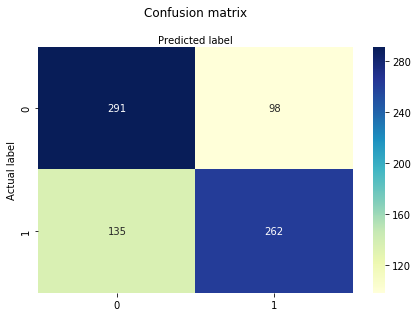

In [36]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Model Parameter Optimization

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]